In [19]:
import torch
from torch import nn
import numpy as np

In [20]:
def corr2d(X, K):
    kh, kw = K.shape
    nh, nw = X.shape
    
    Y = torch.zeros(nh - kh + 1, nw - kw + 1)
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i+kh, j: j+kw] * K).sum()
            
    # print("Y.shape =", Y.shape)
    return Y

In [21]:
X = np.array([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
])

K = np.array([
    [0, 1],
    [2, 3]
])

corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [22]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))  # random initialization
        self.bias = nn.Parameter(torch.zeros(1))  # zero initialization
        
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [23]:
# Image
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [24]:
K = torch.tensor([[1.0, -1.0]])
K.shape

torch.Size([1, 2])

In [25]:
# Edge detection
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [26]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The image has the shape (batch_size, channel_size, height, width)
X = X.reshape((1, 1, 6, 8))  # batch size 1, chanel size 1
Y = Y.reshape((1, 1, 6, 7))  # same with convolution result
lr = 3e-2

for i in range(10):  # 10 epochs
    Y_hat = conv2d(X)  # predicted output via kernel convolution
    l = (Y_hat - Y)**2  # loss (same shape as Y)
    conv2d.zero_grad()  # clear the gradients of kernel weights. If zero_grad() is not called, the gradients from previous iterations would accumulate, leading to incorrect updates.
    l.sum().backward()  # sums up all the elements of the loss tensor l to produce a scalar value and performs backpropagation, computing the gradients of this scalar loss with respect to the model's parameters.
    
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    
    if (i+1)%2 == 0:
        print(f"epoch {i+1}, loss {l.sum():.3f}")

epoch 2, loss 4.077
epoch 4, loss 0.945
epoch 6, loss 0.266
epoch 8, loss 0.088
epoch 10, loss 0.033


In [28]:
# learned weight after training
conv2d.weight.data

tensor([[[[ 0.9730, -1.0090]]]])

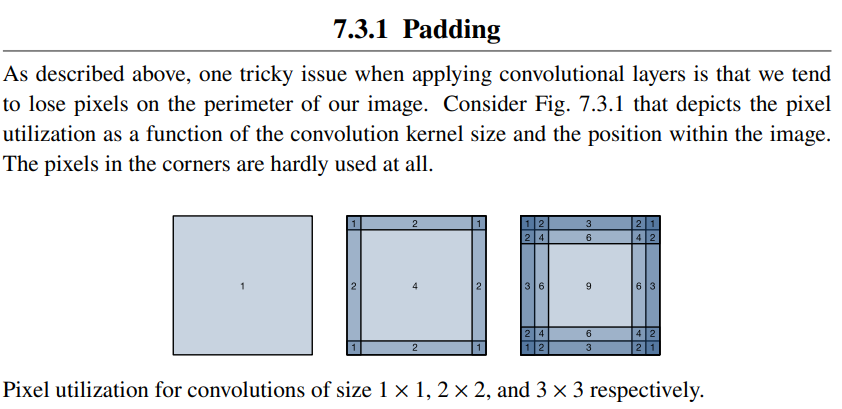

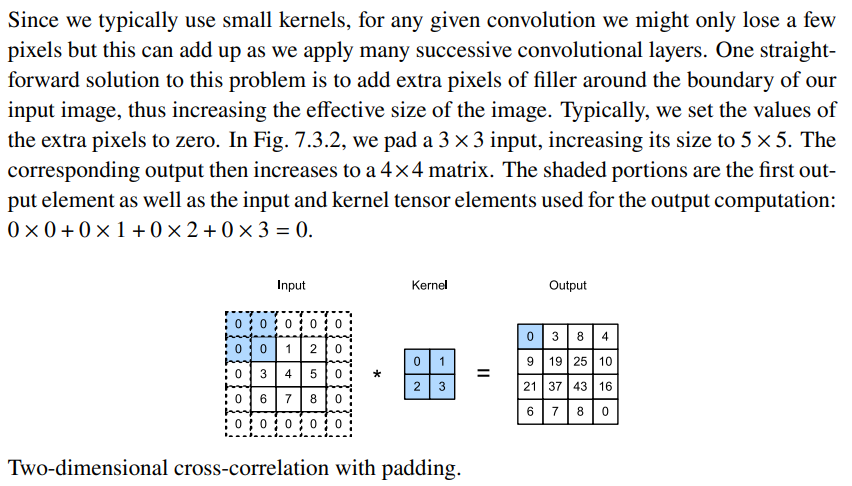

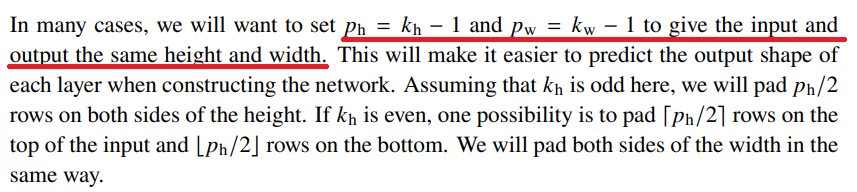

In [38]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)  # batch size 1, channel size 1
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])  # strip batch size and channel size dimensions

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)

In [40]:
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape  # input and output have the same shape

torch.Size([8, 8])

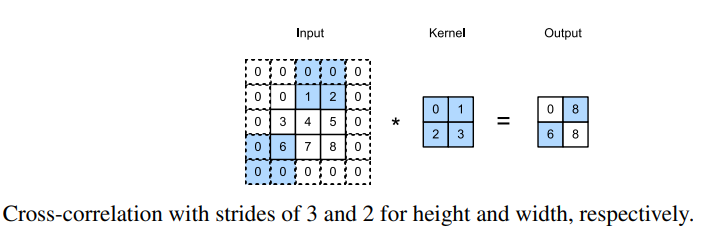

Below, we set the strides on both the height and width to 2, thus halving the input height
and width.

In [41]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [42]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## Multi-channel convolution

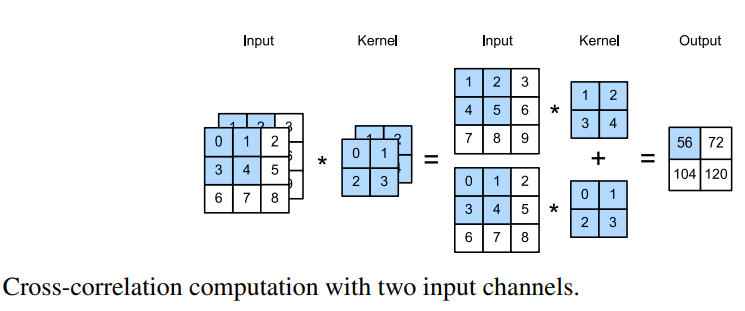

In [47]:
def pool2d(X, pool_size, mode="max"):
    nh, nw = X.shape
    ph, pw = pool_size
    Y = torch.zeros((nh - ph + 1, nw - pw + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == "max":
                Y[i, j] = X[i:i+ph, j:j+pw].max()
            elif mode =="avg":
                Y[i, j] = X[i:i+ph, j:j+pw].mean()
    return Y

In [48]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [50]:
pool2d(X, (2, 2), "max")

tensor([[4., 5.],
        [7., 8.]])

# LeNet architecture (1998)

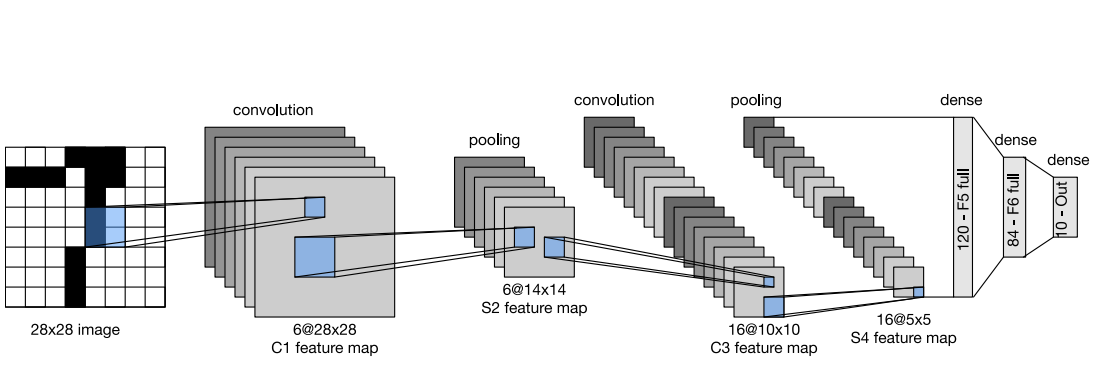

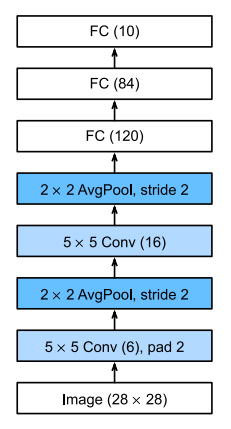

In [51]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)
        
class LeNet(nn.Module):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=(5, 5), padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=(5, 5), stride=2),
            nn.LazyConv2d(out_channels=16, kernel_size=(5, 5), padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=(5, 5), stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=120), nn.Sigmoid(),
            nn.LazyLinear(out_features=84), nn.Sigmoid(),
            nn.LazyLinear(out_features=num_classes), nn.Softmax()
            )
        
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, "output shape:\t", X.shape)
            
model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 12, 12])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
Sigmoid output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 4, 4])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Softmax output shape:	 torch.Size([1, 10])


c:\Users\adevr\WQU_DP\.venv\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
